In [31]:
# coding=utf-8
# Copyleft 2019 project LXRT.

import json
import os
import pickle
from os import path
import numpy as np
import torch
from torch.utils.data import Dataset

#from param import args
from utils import load_obj_tsv

# Copyleft 2019 project LXRT.

import collections
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from pretrain.qa_answer_table import load_lxmert_qa
# from tasks.vqa_model import VQAModel
# from tasks.vqa_data import VQADataset, VQATorchDataset, VQAEvaluator
DataTuple = collections.namedtuple("DataTuple", 'dataset loader evaluator')

# Load part of the dataset for fast checking.
# Notice that here is the number of images instead of the number of data,
# which means all related data to the images would be used.
TINY_IMG_NUM = 512
FAST_IMG_NUM = 5000

# The path to data and image features.
VQA_DATA_ROOT = '../data/vqa/'
MSCOCO_IMGFEAT_ROOT = '../data/mscoco_imgfeat/'
SPLIT2NAME = {
    'train': 'train2014',
    'valid': 'val2014',
    'minival': 'val2014',
    'nominival': 'val2014',
    'test': 'test2015',
}


class VQADataset:
    """
    A VQA data example in json file:
        {
            "answer_type": "other",
            "img_id": "COCO_train2014_000000458752",
            "label": {
                "net": 1
            },
            "question_id": 458752000,
            "question_type": "what is this",
            "sent": "What is this photo taken looking through?"
        }
    """
    def __init__(self, splits: str, subset: str):
        self.name = splits
        self.splits = splits.split(',')
        self.subset = subset
        if subset == 'sports':
            self.filtered = [
                "football",
                "soccer",
                "volleyball",
                "basketball",
                "tennis",
                "badminton",
                "baseball",
                "softball",
                "hockey",
                "golf",
                "racing",
                "rugby",
                "boxing",
                "horse racing",
                "swimming",
                "skiing",
                "snowboarding",
                "water skiing",
                "bowling",
                "biking",
                ]
                
            # Answers
            # self.ans2label = json.load(open("data/vqa/trainval_ans2label.json"))
            # self.label2ans = json.load(open("data/vqa/trainval_label2ans.json"))
            self.ans2label = json.load(open("../data/vqa/trainval_sports_ans2label.json"))
            self.label2ans = json.load(open("../data/vqa/trainval_sports_label2ans.json"))
            assert len(self.ans2label) == len(self.label2ans)

            
            # Loading datasets
            loaded_data = []
            for split in self.splits:
                loaded_data.extend(json.load(open("../data/vqa/%s.json" % split)))
            #print("Load %d data from split(s) %s." % (len(self.data), self.name))
            self.data = []
            for datum in loaded_data:
                if 'label' in datum:
                    if len(datum['label']) > 0:
                        itemMaxValue = max(datum['label'].items(), key=lambda x: x[1]) # Find item with Max Value in list of labels
                        listOfKeys = list()
                        for key, value in datum['label'].items(): # Iterate over all the items in dictionary to find keys with max value
                            if value == itemMaxValue[1]:
                                listOfKeys.append(key)
                        if len(listOfKeys) == 1 and listOfKeys[0] in self.filtered: # ensure there is only one gold label and it is in the desired split
                            new_label ={listOfKeys[0]: itemMaxValue[1]}
                            datum['label'] = new_label
                            self.data.append(datum)
            print("Load %d data from split(s) %s." % (len(self.data), self.name))
        
        elif subset == 'animal':
            self.filtered = ["sheep",  "peacock", "dog", "cardinal", "butterfly", "seagull", "polar bear", "fox", "turkey", "duck", "stork", "bull", "snake", "turtle", "bat", "penguin", 
                            "antelope", "woodpecker", "pony", "canopy", "salmon", "lamb", "bunny", "owl", "horse", "pig", "cow", "pelican", "swan", "elephant", "frog", "ostrich", 
                            "squirrel", "monkey", "bird", "spider", "wildebeest", "crow", "clams", "giraffe", "lizard", "lab", "crane", "alligator", "panda", "kitten", "hawk", 
                            "parrot", "octopus", "mouse", "goat", "tiger", "puppy", "ladybug", "lobster", "whale", "pigeon", "donkey", "goose", "zebra", "blue jay", "parakeet",
                            "worms", "shrimp", "camel", "deer", "shark", "bear", "robin", "dinosaur", "flamingo", "ram", "tuna", "lion", "eagle", "finch", "kangaroo", "elm", "buffalo", 
                            "cat", "pitbull", "leopard", "puma", "rabbit", "chicken", "hummingbird", "dragon", "fish", "cub", "rooster", "orioles"]                
            # Answers
            # self.ans2label = json.load(open("data/vqa/trainval_ans2label.json"))
            # self.label2ans = json.load(open("data/vqa/trainval_label2ans.json"))
            self.ans2label = json.load(open("../data/vqa/trainval_animal_ans2label.json"))
            self.label2ans = json.load(open("../data/vqa/trainval_animal_label2ans.json"))
            assert len(self.ans2label) == len(self.label2ans)

            
            # Loading datasets
            loaded_data = []
            for split in self.splits:
                loaded_data.extend(json.load(open("../data/vqa/%s.json" % split)))
            #print("Load %d data from split(s) %s." % (len(self.data), self.name))
            self.data = []
            for datum in loaded_data:
                if 'label' in datum:
                    if len(datum['label']) > 0:
                        itemMaxValue = max(datum['label'].items(), key=lambda x: x[1]) # Find item with Max Value in list of labels
                        listOfKeys = list()
                        for key, value in datum['label'].items(): # Iterate over all the items in dictionary to find keys with max value
                            if value == itemMaxValue[1]:
                                if key == 'geese':
                                    key = 'goose'
                                listOfKeys.append(key)
                        if len(listOfKeys) == 1 and (listOfKeys[0][-1] == 's' and listOfKeys[0][:-1] in self.filtered): # account for plurals
                            listOfKeys[0] = listOfKeys[0][:-1]
                        if len(listOfKeys) == 1 and (listOfKeys[0] in self.filtered): # ensure there is only one gold label and it is in the desired split
                            new_label ={listOfKeys[0]: itemMaxValue[1]}
                            datum['label'] = new_label
                            self.data.append(datum)
            print("Load %d data from split(s) %s." % (len(self.data), self.name))

            # Convert list to dict (for evaluation)
            self.id2datum = {
                datum['question_id']: datum
                for datum in self.data
            }
        else:
            # Loading datasets
            self.data = []
            for split in self.splits:
                self.data.extend(json.load(open("../data/vqa/%s.json" % split)))
            print("Load %d data from split(s) %s." % (len(self.data), self.name))

            # Convert list to dict (for evaluation)
            self.id2datum = {
                datum['question_id']: datum
                for datum in self.data
            }

            # Answers
            self.ans2label = json.load(open("../data/vqa/trainval_ans2label.json"))
            self.label2ans = json.load(open("../data/vqa/trainval_label2ans.json"))
            assert len(self.ans2label) == len(self.label2ans)

    @property
    def num_answers(self):
        return len(self.ans2label)

    def __len__(self):
        return len(self.data)


"""
An example in obj36 tsv:
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]
FIELDNAMES would be keys in the dict returned by load_obj_tsv.
"""
class VQATorchDataset(Dataset):
    def __init__(self, dataset: VQADataset):
        super().__init__()
        self.raw_dataset = dataset

        # if args.tiny:
        #     topk = TINY_IMG_NUM
        # elif args.fast:
        #     topk = FAST_IMG_NUM
        # else:
        topk = None

        # Loading detection features to img_data
        img_data = []
        for split in dataset.splits:
            # Minival is 5K images in MS COCO, which is used in evaluating VQA/LXMERT-pre-training.
            # It is saved as the top 5K features in val2014_***.tsv
            load_topk = 5000 if (split == 'minival' and topk is None) else topk
            img_data.extend(load_obj_tsv(
                os.path.join(MSCOCO_IMGFEAT_ROOT, '%s_obj36.tsv' % (SPLIT2NAME[split])),
                topk=load_topk))

        # Convert img list to dict
        self.imgid2img = {}
        for img_datum in img_data:
            self.imgid2img[img_datum['img_id']] = img_datum

        # Only kept the data with loaded image features
        self.data = []
        for datum in self.raw_dataset.data:
            if datum['img_id'] in self.imgid2img:
                self.data.append(datum)
        print("Use %d data in torch dataset" % (len(self.data)))
        print()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item: int):
        datum = self.data[item]

        img_id = datum['img_id']
        ques_id = datum['question_id']
        ques = datum['sent']

        # Get image info
        img_info = self.imgid2img[img_id]
        obj_num = img_info['num_boxes']
        feats = img_info['features'].copy()
        boxes = img_info['boxes'].copy()
        assert obj_num == len(boxes) == len(feats)

        # Normalize the boxes (to 0 ~ 1)
        img_h, img_w = img_info['img_h'], img_info['img_w']
        boxes = boxes.copy()
        boxes[:, (0, 2)] /= img_w
        boxes[:, (1, 3)] /= img_h
        np.testing.assert_array_less(boxes, 1+1e-5)
        np.testing.assert_array_less(-boxes, 0+1e-5)

        if 'label' in datum:
            label = datum['label']
            target = torch.zeros(self.raw_dataset.num_answers)
            if self.raw_dataset.subset != None:
                assert len(label) == 1 # ensure there is only one gold label
                for ans, score in label.items():
                    if ans in self.raw_dataset.filtered: # double check the if answer is in filtered category
                        target[self.raw_dataset.ans2label[ans]] = 1.0
                target = torch.squeeze(target.nonzero())
            else:
                for ans, score in label.items():
                    target[self.raw_dataset.ans2label[ans]] = score
            return ques_id, feats, boxes, ques, target, img_id
        else:
            return ques_id, feats, boxes, ques


class VQAEvaluator:
    def __init__(self, dataset: VQADataset):
        self.dataset = dataset

    def evaluate(self, quesid2ans: dict):
        score = 0.
        for quesid, ans in quesid2ans.items():
            datum = self.dataset.id2datum[quesid]
            label = datum['label']
            if ans in label:
                score += label[ans]
        return score / len(quesid2ans)

    def dump_result(self, quesid2ans: dict, path):
        """
        Dump results to a json file, which could be submitted to the VQA online evaluation.
        VQA json file submission requirement:
            results = [result]
            result = {
                "question_id": int,
                "answer": str
            }

        :param quesid2ans: dict of quesid --> ans
        :param path: The desired path of saved file.
        """
        with open(path, 'w') as f:
            result = []
            for ques_id, ans in quesid2ans.items():
                result.append({
                    'question_id': ques_id,
                    'answer': ans
                })
            json.dump(result, f, indent=4, sort_keys=True)


def get_data_tuple(splits: str, subset: str, bs:int, shuffle=False, drop_last=False) -> DataTuple:
    dset = VQADataset(splits, subset)
    if splits != 'minival':
        index_dset = len(dset.data) % bs
        if index_dset != 0:
            dset.data = dset.data[:-index_dset] 
    tset = VQATorchDataset(dset)
    if splits != 'minival':
        index_tset = len(tset.data) % bs
        if index_tset != 0:
            tset.data = tset.data[:-index_tset]
    evaluator = VQAEvaluator(dset)
    data_loader = DataLoader(
        tset, batch_size=bs,
        shuffle=shuffle, num_workers=0,
        drop_last=drop_last, pin_memory=True
    )
    return DataTuple(dataset=dset, loader=data_loader, evaluator=evaluator)


In [51]:
def generate_datamap_metadata(filename, dset, loader):
    iter_wrapper = (lambda x: x)
    with open(filename) as fp:
        listObj = json.load(fp)
    print(type(listObj))
    for i, (ques_id, feats, boxes, sent, target, img_id) in iter_wrapper(enumerate(loader)):
        for idx, question in enumerate(sent):
            label_gt = target[idx].numpy().astype(int)
            ans_gt = dset.label2ans[np.squeeze(label_gt)]
            listObj.append({
                "Question ID": int(ques_id[idx]),
                "Image ID": str(img_id[idx]),
                "Question": str(question),
                "Target": str(ans_gt),
                "Target idx": int(label_gt)
            })


    with open(filename, 'w') as json_file:
        json.dump(listObj, json_file, 
                            indent=4,  
                            separators=(',',': '))

    targets = []

    for i in listObj:
        targets.append(i['Target'])

    df = pd.DataFrame({'freq': targets})
    df.groupby('freq', as_index=True).size().plot(kind='bar')
    plt.figure(figsize=(50,2))
    plt.show()

Load 310 data from split(s) minival.
Start to load Faster-RCNN detected objects from ../data/mscoco_imgfeat/val2014_obj36.tsv
Loaded 5000 images in file ../data/mscoco_imgfeat/val2014_obj36.tsv in 18 seconds.
Use 310 data in torch dataset

<class 'list'>


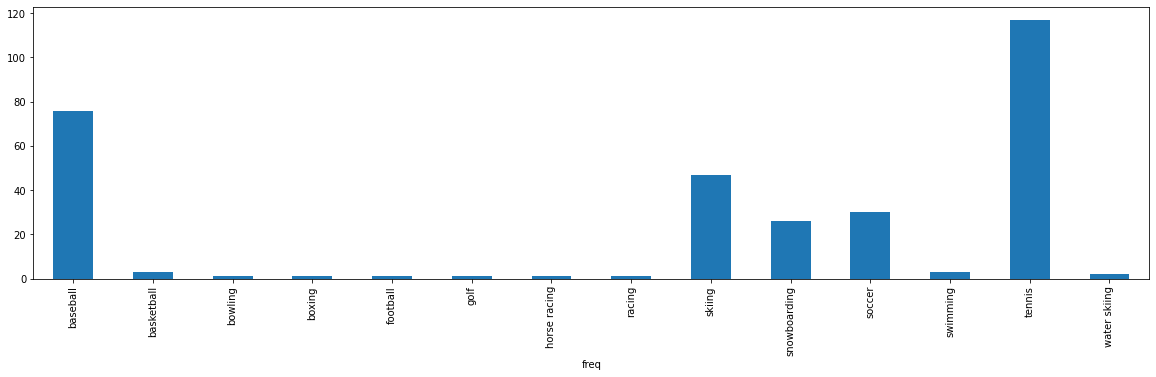

<Figure size 3600x144 with 0 Axes>

In [46]:
# sports 
val_filename = '../data/vqa/datamap_metadata/val_sports.json'
val_dset, val_loader, val_evaluator = get_data_tuple('minival', 'sports', bs=1024, shuffle=False, drop_last=False)
generate_datamap_metadata(val_filename, val_dset, val_loader)
#train_filename = '../data/vqa/datamap_metadata/train_sports.json'
#train_dset, train_loader, train_evaluator = get_data_tuple('train,nominival', 'sports', bs=32, shuffle=True, drop_last=False)
#generate_datamap_metadata(train_filename, train_dset, train_loader)


Load 521 data from split(s) minival.
Start to load Faster-RCNN detected objects from ../data/mscoco_imgfeat/val2014_obj36.tsv
Loaded 5000 images in file ../data/mscoco_imgfeat/val2014_obj36.tsv in 19 seconds.
Use 521 data in torch dataset

<class 'list'>


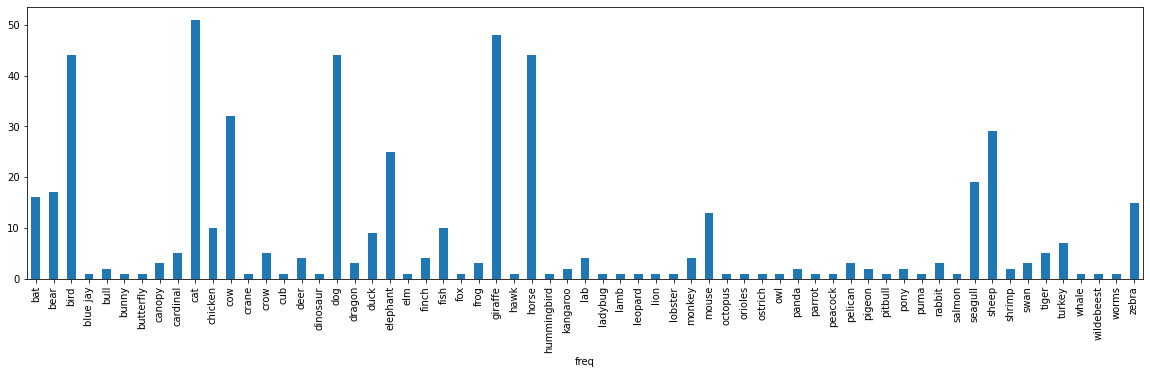

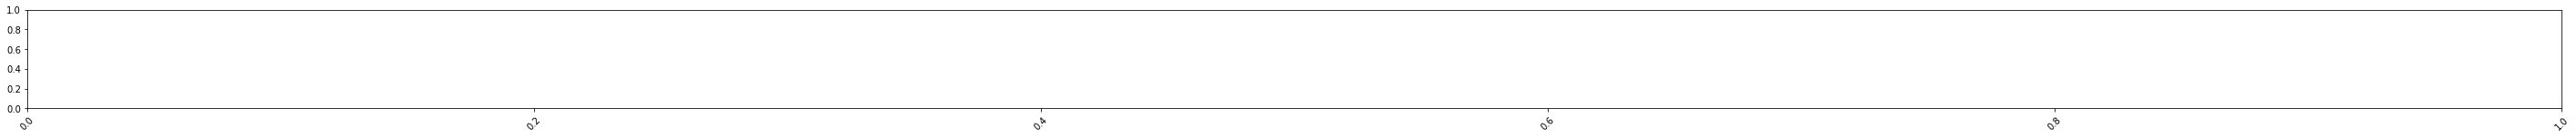

In [52]:
# animals
plt.rcParams['figure.figsize'] = [20, 5]

val_filename = '../data/vqa/datamap_metadata/val_animal.json'
val_dset, val_loader, val_evaluator = get_data_tuple('minival', 'animal', bs=1024, shuffle=False, drop_last=False)
generate_datamap_metadata(val_filename, val_dset, val_loader)

Load 13229 data from split(s) train,nominival.
Start to load Faster-RCNN detected objects from ../data/mscoco_imgfeat/train2014_obj36.tsv
Loaded 82783 images in file ../data/mscoco_imgfeat/train2014_obj36.tsv in 333 seconds.
Start to load Faster-RCNN detected objects from ../data/mscoco_imgfeat/val2014_obj36.tsv
Loaded 40504 images in file ../data/mscoco_imgfeat/val2014_obj36.tsv in 167 seconds.
Use 13216 data in torch dataset

<class 'list'>


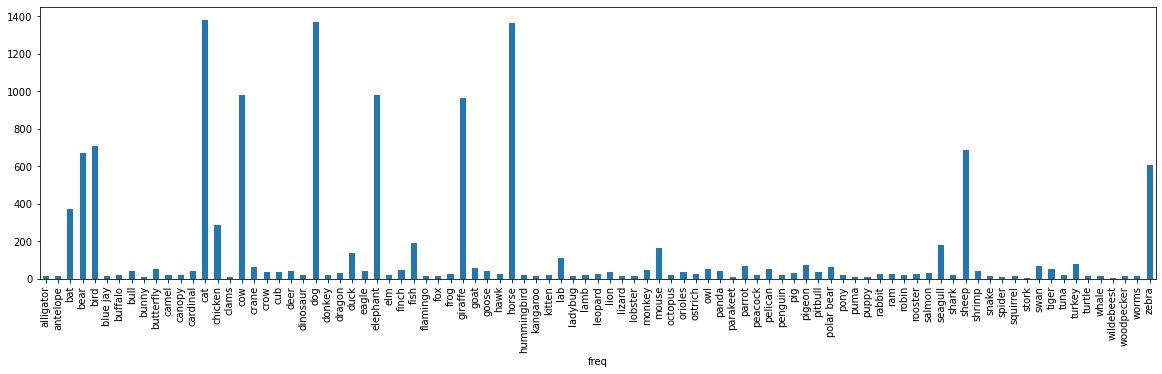

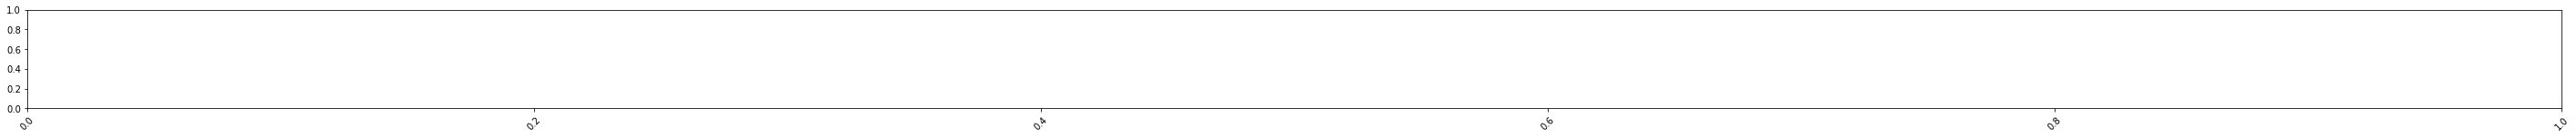

In [53]:
train_filename = '../data/vqa/datamap_metadata/train_animal.json'
train_dset, train_loader, train_evaluator = get_data_tuple('train,nominival', 'animal', bs=32, shuffle=True, drop_last=False)

generate_datamap_metadata(train_filename, train_dset, train_loader)